In [ ]:
pip install git+https://github.com/forrestbao/pyeeg.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-pwji8_4y
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-pwji8_4y
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28123 sha256=5e08753dd3c77056462f2a31c1f1afe7cd533577ce01a0b40260d911b11860f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-1juo2h4n/wheels/2d/3f/ad/106d4fc80b61d1ea1fc18e76e7439fd98aa043d83d58eae741
Successfully built pyeeg


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyeeg

In [ ]:
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
#import tensorflow as tf
import time

In [ ]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+

band = [4,8,12,16,25,45] #5 bands

window_size = 256 #Averaging band power of 2 sec

step_size = 16 #Each 0.125 sec update once

sample_rate = 128 #Sampling rate of 128 Hz

subjectList=[]
for i in range(1,33):
  if i<10:
     subjectList.append(f"{i:02d}")
  else:
    subjectList.append(f"{i:2d}")

print(subjectList)

#List of subjects
path_to_dataset_2 = '/content/drive/MyDrive/Thesis/DEAP-dataset/Datasets/dat_File_Folder/'
path_to_dataset = '/content/drive/MyDrive/Thesis/DEAP-dataset/Datasets/testing_model_5/'

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']


In [ ]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open(path_to_dataset_2+'s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        #np.save('C:/Users/faizan/Downloads/data_preprocessed_python/data_preprocessed_python/s' + sub, meta, allow_pickle=True, fix_imports=True)
        np.save(path_to_dataset+'s' + sub, meta, allow_pickle=True, fix_imports=True)

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open(path_to_dataset + 's' + subjects + '.npy', 'rb') as file:
        sub = np.load(file)
        for i in range (0,sub.shape[0]):
            if i % 8 == 0:
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
            else:
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])
          

In [ ]:
# restore np.load for future normal usage
np.load = np_load_old

In [ ]:
np.save(path_to_dataset + 'data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(path_to_dataset + 'data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (546560, 70) (546560, 4)
testing dataset: (78080, 70) (78080, 4)


In [ ]:
with open(path_to_dataset + 'data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [1]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

In [2]:
!pip install keras_visualizer

In [10]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.models import Model
import timeit
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
from keras.optimizers import SGD
from keras_visualizer import visualizer 
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(Z)
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
x_train = np.array(X[:])

In [ ]:
with open(path_to_dataset + 'data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [1]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [ ]:
x_test = np.array(M[:])
x_test

array([[0.07006464, 0.10438554, 0.06634758, ..., 0.10698754, 0.14264875,
        0.12007955],
       [0.07546743, 0.08606705, 0.07999725, ..., 0.12147734, 0.13970255,
        0.12824657],
       [0.11370435, 0.09387804, 0.07056466, ..., 0.11339237, 0.11484593,
        0.10770615],
       ...,
       [0.17484635, 0.1135094 , 0.05917121, ..., 0.03334964, 0.05135839,
        0.07198122],
       [0.20681713, 0.10186689, 0.0540274 , ..., 0.02499636, 0.05249084,
        0.05879238],
       [0.17817637, 0.08834064, 0.05389381, ..., 0.03475489, 0.05801423,
        0.06873259]])

In [ ]:
from keras.utils import to_categorical
y_test = to_categorical(L)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [ ]:
x_train.shape

(546560, 70, 1)

In [ ]:
batch_size = 256
num_classes = 10
epochs = 20
input_shape=(x_train.shape[1], 1)

In [ ]:
print(input_shape)

(70, 1)


In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [16]:
model = Sequential()

input_shape=(70, 1)

model.add(Conv1D(1024, kernel_size=9,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(512,kernel_size=6,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(256,kernel_size=6,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(128,kernel_size=6,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 70, 1024)          10240     
_________________________________________________________________
batch_normalization_8 (Batch (None, 70, 1024)          4096      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 35, 1024)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 35, 512)           3146240   
_________________________________________________________________
batch_normalization_9 (Batch (None, 35, 512)           2048      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 17, 512)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 17, 256)          

In [15]:
visualizer(model, format='png', view=True)

ValueError: ignored

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

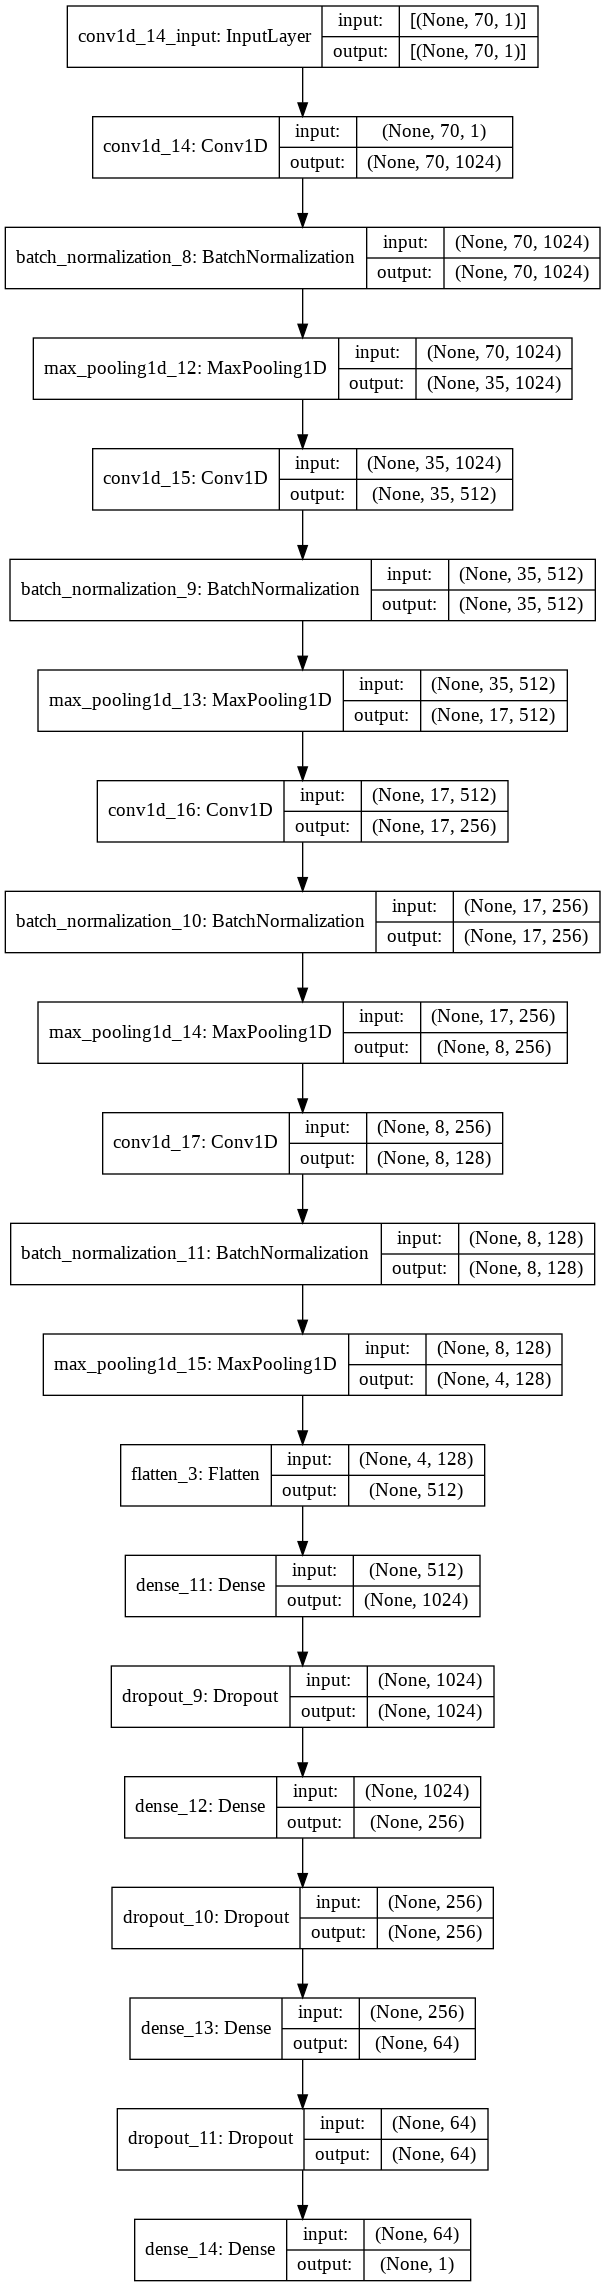

In [17]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Automatic save 

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/MyDrive/Thesis/DEAP-dataset/Saved_checkpoints/testing_model_5/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=15)
callbacks_list = [es, checkpoint]

/content/drive/MyDrive/Thesis/DEAP-dataset/Saved_checkpoints/testing_model_5/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


Epoch 1/20
2135/2135 [==============================] - 171s 76ms/step - loss: 1.8125 - accuracy: 0.2986

Epoch 00001: accuracy improved from -inf to 0.34399, saving model to /content/drive/MyDrive/Thesis/DEAP-dataset/Saved_checkpoints/testing_model_5/weights-improvement-01-0.3440.hdf5
Epoch 2/20
2135/2135 [==============================] - 165s 77ms/step - loss: 1.4178 - accuracy: 0.4507

Epoch 00002: accuracy improved from 0.34399 to 0.47787, saving model to /content/drive/MyDrive/Thesis/DEAP-dataset/Saved_checkpoints/testing_model_5/weights-improvement-02-0.4779.hdf5
Epoch 3/20
2135/2135 [==============================] - 165s 77ms/step - loss: 1.1405 - accuracy: 0.5651

Epoch 00003: accuracy improved from 0.47787 to 0.58290, saving model to /content/drive/MyDrive/Thesis/DEAP-dataset/Saved_checkpoints/testing_model_5/weights-improvement-03-0.5829.hdf5
Epoch 4/20
2135/2135 [==============================] - 164s 77ms/step - loss: 0.9355 - accuracy: 0.6498

Epoch 00004: accuracy impro

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2440/2440 [==============================] - 12s 5ms/step - loss: 0.3399 - accuracy: 0.8948
Test loss: 0.33986252546310425
Test accuracy: 0.8947746157646179
